In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from numba import jit
from scipy.interpolate import interp1d

In [2]:
k10=np.load("prueba_10k.npy")
k20=np.load("prueba_20k.npy")
k50=np.load("prueba_50k.npy")
k250=np.load("prueba_250k.npy")

In [3]:
ksi10k=np.load("ksi10k.npy")
ksi20k=np.load("ksi20k.npy")
ksi50k=np.load("ksi50k.npy")
ksi250k=np.load("ksi250k.npy")
ksils10k=np.load("ksils10k.npy")
ksils20k=np.load("ksils20k.npy")
ksils50k=np.load("ksils50k.npy")
ksils250k=np.load("ksils250k.npy")

In [44]:
@jit
def cubo(puntos,dim,lado):
    '''
    Genera puntos con coordenadas de la dimension que se indique dentro de un cubo de lado que se indique 
    puntos: Cantidad de puntos que se quieren generar
    lado: tamaño del lado del cubo
    dim: número de dimensiones del cubo
    '''
    return np.random.uniform(0,lado,size=(puntos,dim))

@jit
def dist(p1,p2):
    '''
    Calcula la distancia mediante el teorema de pitágoras entre el punto p1 y el punto p2.
    Acepta puntos cualquier dimensión.
    '''
    return np.sqrt(np.sum(np.square(p1-p2)))


@jit
def ksi(puntos,dist,bins=50):
    '''
    Calcula la función ksi(r) de un conjunto de puntos dada una función de distancia dist.
    Las coordenadas de los puntos no pueden ser negativas, deben desplazarse hacia números positivos para
    servir en esta función.
    Por default divide en 50 intervalos el rango entre 0 y la máxima distancia en un cubo que encierre a todos
    los puntos.
    '''
    dim=len(puntos[0])
    l=np.max(puntos)
    puntosu=cubo(len(puntos),dim,l)

    maxdist=np.sqrt(dim*l**2)
    
    DD=np.zeros(bins)
    RR=np.zeros(bins)
    for i  in range(len(puntos)):
        for j in range(len(puntos)):
            if(i>j):
                DD[int(np.floor(dist(puntos[i],puntos[j])/(maxdist/bins)))]+=1
                RR[int(np.floor(dist(puntosu[i],puntosu[j])/(maxdist/bins)))]+=1

    centros=[maxdist/bins*(1+2*i)/2 for i in range(bins)]
    
    RRzero=(RR==0)
    RR[RRzero]=1
    
    ksi=(DD/RR-1,centros)
    
    ksi[0][RRzero]=np.nan
    return ksi


@jit
def ksils(puntos,dist,bins=50):
    '''
    Calcula la función ksi(r) de Landy-Szalay de un conjunto de puntos dada una función de distancia "dist".
    Las coordenadas de los puntos no pueden ser negativas, deben desplazarse hacia números positivos para
    servir en esta función.
    Por default divide en 50 intervalos el rango entre 0 y la máxima distancia en un cubo que encierre a todos
    los puntos.
    '''
    dim=len(puntos[0])
    l=np.max(puntos)
    puntosu=cubo(len(puntos),dim,l)
    maxdist=np.sqrt(dim*l**2)

    DD=np.zeros(bins)
    RR=np.zeros(bins)
    for i  in range(len(puntos)):
        for j in range(len(puntos)):
            if(i>j):
                DD[int(np.floor(dist(puntos[i],puntos[j])/maxdist*bins))]+=1
                RR[int(np.floor(dist(puntosu[i],puntosu[j])/maxdist*bins))]+=1

    DR=np.zeros(bins)
    for i  in range(len(puntos)):
        for j in range(len(puntos)):
            DR[int(np.floor(dist(puntos[i],puntosu[j])/maxdist*bins))]+=1

    centros=[maxdist/bins*(1+2*i)/2 for i in range(bins)]

    nop=len(puntos)
    nDD=nop*(nop-1)/2
    nRR=nDD
    nDR=nop**2

    ksi=((DD/nDD+RR/nRR-2*DR/nDR)/(RR/nRR),centros)
    return ksi

In [25]:
#Read the true power spectrum used to generate the simulation. 
Pk=np.loadtxt('../Remoto_Semana7/input_spectrum.dat')
pk_=interp1d(Pk[:,0],Pk[:,1])
kh=10**np.linspace(-4,2,5000)
def xi_true():
    pk_h=pk_(kh)
    # Compute the correlation  function from the true  P(k) used in the simulation. Fourier Transform. 
    kstart =0
    kcut = 10
    kcut_ind = np.argmin(abs(kh - kcut))
#print 'kcut_ind=', kcut_ind
#print 'kcut=', kh[kcut_ind]

    r_start = 1
    r_end = 150
    r_stepsize = 1
    r_list = np.arange(r_start, r_end, r_stepsize)

    xi = np.zeros(len(r_list))
    factor = np.power(kh[kstart:kcut_ind],2) * pk_h[kstart:kcut_ind] / (kh[kstart:kcut_ind]*2*np.pi**2)
    for i in range(0, len(r_list)):
        IntegrandXi0 = factor * np.sin(kh[kstart:kcut_ind]*r_list[i]) / r_list[i]
        xi[i] = np.trapz(IntegrandXi0,kh[kstart:kcut_ind])
    return r_list, xi

In [39]:
def graf(KSI,nombre,recorte=[0,250]):
    fig, ax = plt.subplots(4,figsize=[8,10])
    ax=plt.subplot(2, 1, 1)
    ax.plot(KSI[1][recorte[0]+5:recorte[1]],KSI[0][recorte[0]+5:recorte[1]],"r")
    ax.set_ylabel(r'$\xi (r)$')
    ax.set_xlabel(r'$r$')
    ax.set_title('Correlación'+nombre[0]+' en función de la distancia '+nombre[1])

    ax=plt.subplot(2, 1, 2)
    ax.plot(KSI[1][recorte[0]:recorte[1]],KSI[0][recorte[0]:recorte[1]]*np.square(KSI[1][recorte[0]:recorte[1]]),"b")
    ax.set_ylabel(r'$\xi (r) \cdot r^2$')
    ax.set_xlabel(r'$r$')
    ax.set_title('Correlación'+nombre[0]+' por distancia al cuadrado '+nombre[1])
    
    
def graf2(KSIs,compact,nombre,j,recorte=[0,250]):
    grafs=len(KSIs)
    KSI=[compactbins(KSIs[i],compact) for i in range(grafs)]
    puntos=("10k","20k","50k","250k")
    r_,xi=xi_true()
    
    for i in range(grafs):
        plt.plot(KSI[i][1][recorte[0]:recorte[1]],KSI[i][0][recorte[0]:recorte[1]]*np.square(KSI[i][1][recorte[0]:recorte[1]]),label=puntos[j[i]])
    #plt.xlim(0,200)
    #plt.ylim(-20,50)
    plt.plot(r_, np.power(r_,2)*xi ,label='Linear')
    plt.ylabel(r'$\xi (r) \cdot r^2$')
    plt.xlabel(r'$r$')
    plt.title('Correlación'+nombre+' en función de la distancia')
    plt.legend()

    
def compactbins(KSI,div):
    new=np.zeros((2,int(len(KSI[0])/div)))
    for i in range(int(len(KSI[0])/div)):
        for j in range(div):
            new[0][i]+=KSI[0][i*div+j]
            new[1][i]+=KSI[1][i*div+j]

    new=new/div
    return new

In [45]:
start_time = time.time()
ksi10k=ksi(k10,dist,bins=900)
print("ksi10k: %s seconds" % (time.time() - start_time))
np.save('ksi10k.npy', ksi10k)

ksi10k: 17.73781991004944 seconds


In [12]:
start_time = time.time()
ksi20k=ksi(k20,dist,bins=900)
print("ksi20k: %s seconds" % (time.time() - start_time))
np.save('ksi20k.npy', ksi20k)

ksi20k: 62.70755338668823 seconds


In [11]:
start_time = time.time()
ksi50k=ksi(k50,dist,bins=900)
print("ksi50k: %s seconds" % (time.time() - start_time))
np.save('ksi50k.npy', ksi50k)

ksi50k: 375.97237730026245 seconds


In [133]:
start_time = time.time()
ksils10k=ksils(k10,dist,bins=900)
print("ksils10k: %s seconds" % (time.time() - start_time))
np.save('ksils10k.npy', ksils10k)

ksils10k: 33.830042123794556 seconds


In [134]:
start_time = time.time()
ksils210k=ksils2(k10,dist,bins=900)
print("ksils10k: %s seconds" % (time.time() - start_time))
np.save('ksils10k.npy', ksils10k)

ksils10k: 31.4673969745636 seconds


In [44]:
start_time = time.time()
ksils20k=ksils2(k20,dist,bins=900)
print("ksils20k: %s seconds" % (time.time() - start_time))
np.save('ksils20k.npy', ksils20k)

ksils20k: 122.0553457736969 seconds


In [45]:
start_time = time.time()
ksils50k=ksils(k50,dist,bins=900)
print("ksi1: %s seconds" % (time.time() - start_time))
np.save('ksils50k.npy', ksils50k)

ksi1: 810.8491930961609 seconds


In [8]:
start_time = time.time()
ksi250k=ksi(k250,dist,bins=900)
print("ksi1: %s seconds" % (time.time() - start_time))
np.save('ksi250k.npy', ksi250k)

ksi1: 9510.390659093857 seconds


In [ ]:
start_time = time.time()
ksils250k=ksils(k250,dist,bins=900)
print("ksi1: %s seconds" % (time.time() - start_time))
np.save('ksils250k.npy', ksils250k)

Text(0.5, 0, 'x')

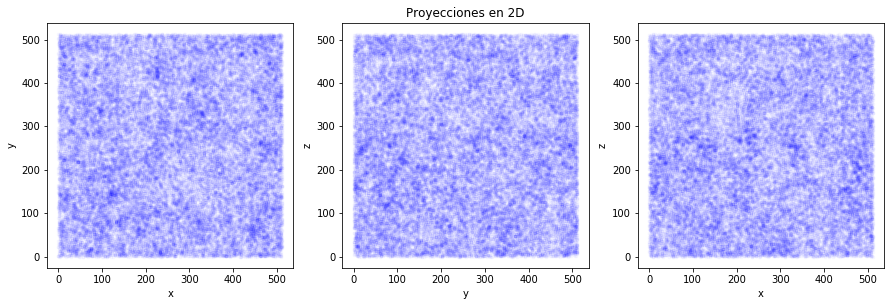

In [58]:
#Proyecciones en 2D
fig, ax = plt.subplots(10,figsize=[15,4.5])
ax=plt.subplot(1, 3, 1)
ax.plot(k50[:,0],k50[:,1],'b.', alpha=0.02)
ax.set_ylabel('y')
ax.set_xlabel('x')

ax=plt.subplot(1, 3, 2)
ax.plot(k50[:,1],k50[:,2],'b.', alpha=0.02)
ax.set_ylabel('z')
ax.set_xlabel('y')
ax.set_title('Proyecciones en 2D')

ax=plt.subplot(1, 3, 3)
ax.plot(k50[:,0],k50[:,2],'b.', alpha=0.02)
ax.set_ylabel('z')
ax.set_xlabel('x')

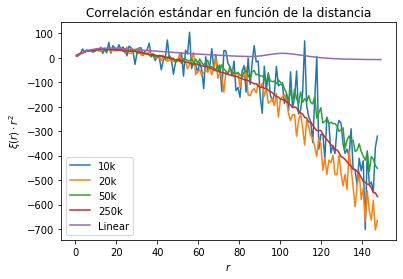

In [40]:
graf2([ksi10k,ksi20k,ksi50k,ksi250k],1," estándar",[0,1,2,3],recorte=(0,150))

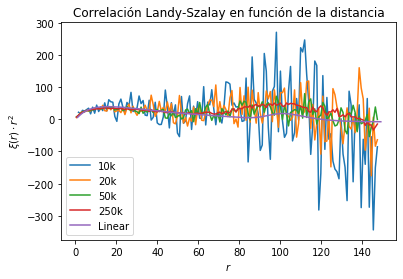

In [42]:
graf2([ksils10k,ksils20k,ksils50k,ksils250k],1," Landy-Szalay",[0,1,2,3],recorte=(0,150))

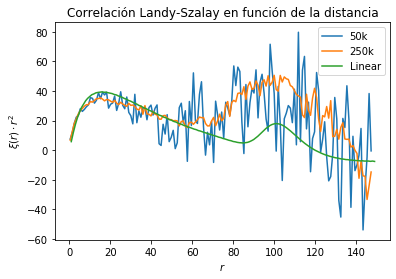

In [43]:
graf2([ksils50k,ksils250k],1," Landy-Szalay",[2,3],recorte=(0,150))